<h1> UNDER CONSTRUCTION </h1>

Caso de uso de LSDB + dados S-PLUS (DR4) + Crossmatch

1 - Diagrama cor X cor ou cor x mag: Fazer um cone-search em volta de algum cluster de galáxias e fazer um crossmatch com o VAC de identificação de galáxias
1.1 - Podemos fazer alguns plots de espectros (auto) desses objetos, por exemplo, buscar os 5 que possuem J0660 maior.

2 - Diagrama HR (esse é um pouco mais chatinho pq tem que fazer um crossmatch com os dados do GAIA3 e procurar as distâncias para calcular a magnitude absoluta)

Parte técnica:

    1 - splusdata: buscar servidores HiPSCat com os catálogos de dados do S-PLUS
    2 - LSDB: Criar cliente dask para paralelismo e ler os catalogos escolhidos e as colunas escolhidas
    3 - fazer o crossmatch (sem e com filtragem dos dados)
    4 - fazer a busca (cone ou box) e computar as tabelas finais
    5 - cozinha com os dados e fazer plots bonitos
    6 - BONUS crosmatch com arquivos ?

In [1]:
import lsdb
import splusdata
import numpy as np
from dask.distributed import Client
from matplotlib import pyplot as plt

In [2]:
# Start a Dask client for the parallel process used by lsdb
client = Client(n_workers=10, memory_limit='8GB')
print(client) 

<Client: 'tcp://127.0.0.1:42611' processes=10 threads=20, memory=74.51 GiB>


In [3]:
# List HiPSCat catalogs available on S-PLUS servers
def print_dict(d, i=0):
    for k, v in d.items():
        print('\t'*i + str(k))
        if isinstance(v, dict):
            print_dict(v, i+1)
        else:
            print('\t'*(i+1) + str(v))
print_dict(splusdata.get_hipscats())

dr4_vacs
	qso_z
		hipscats
			['qso_z']
		margins
			['qso_z_2arcsec']
	photozs
		hipscats
			['photozs']
		margins
			['photozs_2arcsec']
	calib_flag
		hipscats
			['calib_flag']
		margins
			['calib_flag_2arcsec']
	sqg
		hipscats
			['sqg']
		margins
			['sqg_2arcsec']
sdr1
	hipscats
		['shorts']
	margins
		['shorts_2arcsec']
dr4
	hipscats
		['single', 'dual', 'psf']
	margins
		['psf_2arcsec', 'single_2arcsec', 'dual_2arcsec']


In [4]:
# search for the full S-PLUS DR4/dual mode catalog
'''
What is the difference between ‘single’, ‘dual’ and ‘psf’?
Single yields photometry done using Sextractor on each image, 
for a given filter, using only that image as a detection image. 
Note that in this case, measured parameters such as radii are 
different for each filter. Dual yields photometry done using 
Sextractor on each image, for a given filter, using as a 
detection image the sum of g+r+i+z. Therefore, in dual mode, 
detections characterized in the same way are measured in every 
filter. Psf yields photometry done using dophot on each image, 
for a given filter, using only that image as a detection image. 
See Section ‘Photometry’ for more details.

Photometry Section: 
    https://splus.cloud/documentation/DR4?Photometry
'''
dr4dual_search = splusdata.get_hipscats('dr4/dual')
# Print all catalogs found with the pattern above
print(f'dr4/dual search: {dr4dual_search}')
# select the first catalog found
dr4dual_hipscat, dr4dual_margin_cache_hipscat = dr4dual_search[0]

# Search for the DR4 Star Galaxy Quasar VAC
'''
QSO/star/galaxy classification VAC: 
    https://splus.cloud/documentation/DR4?QSO/star/galaxy_classification
'''
dr4sqg_search = splusdata.get_hipscats('dr4/sqg')
# Print all catalogs found with the pattern above
print(f'dr4/sqg search: {dr4sqg_search}')
# select the first catalog found
dr4sqg_hipscat, dr4sqg_margin_cache_hipscat = dr4sqg_search[0]

dr4/dual search: [['https://splus.cloud/HIPS/catalogs/dr4/dual/', 'https://splus.cloud/HIPS/catalogs/dr4/dual_2arcsec/']]
dr4/sqg search: [['https://splus.cloud/HIPS/catalogs/dr4_vacs/sqg/sqg/', 'https://splus.cloud/HIPS/catalogs/dr4_vacs/sqg/sqg_2arcsec/']]


In [5]:
bands = [
    'u', 'g', 'r', 'i', 'z', 
    'J0378', 'J0395', 'J0410',
    'J0430', 'J0515', 'J0660', 'J0861',
]
columns = ['ID', 'Field', 'RA', 'DEC'] + [f'{b}_auto' for b in bands] + [f's2n_{b}_auto' for b in bands]
print('Columns:', columns)
filters = [(f's2n_{b}_auto', '>', 3) for b in bands]
print('Filters', filters)

Columns: ['ID', 'Field', 'RA', 'DEC', 'u_auto', 'g_auto', 'r_auto', 'i_auto', 'z_auto', 'J0378_auto', 'J0395_auto', 'J0410_auto', 'J0430_auto', 'J0515_auto', 'J0660_auto', 'J0861_auto', 's2n_u_auto', 's2n_g_auto', 's2n_r_auto', 's2n_i_auto', 's2n_z_auto', 's2n_J0378_auto', 's2n_J0395_auto', 's2n_J0410_auto', 's2n_J0430_auto', 's2n_J0515_auto', 's2n_J0660_auto', 's2n_J0861_auto']
Filters [('s2n_u_auto', '>', 3), ('s2n_g_auto', '>', 3), ('s2n_r_auto', '>', 3), ('s2n_i_auto', '>', 3), ('s2n_z_auto', '>', 3), ('s2n_J0378_auto', '>', 3), ('s2n_J0395_auto', '>', 3), ('s2n_J0410_auto', '>', 3), ('s2n_J0430_auto', '>', 3), ('s2n_J0515_auto', '>', 3), ('s2n_J0660_auto', '>', 3), ('s2n_J0861_auto', '>', 3)]


In [6]:
dr4dual = lsdb.read_hipscat(
    dr4dual_hipscat,
    # Read more about the need of the margin cache server at:
    #      https://lsdb.readthedocs.io/en/stable/tutorials/margins.html    
    margin_cache=lsdb.read_hipscat(dr4dual_margin_cache_hipscat),
    # Read more about the available columns at:
    #      https://splus.cloud/documentation/DR4?Schemas,_tables_and_columns
    columns=columns,
    #filters=filters,
)

In [7]:
dr4dual.columns

Index(['ID', 'Field', 'RA', 'DEC', 'u_auto', 'g_auto', 'r_auto', 'i_auto',
       'z_auto', 'J0378_auto', 'J0395_auto', 'J0410_auto', 'J0430_auto',
       'J0515_auto', 'J0660_auto', 'J0861_auto', 's2n_u_auto', 's2n_g_auto',
       's2n_r_auto', 's2n_i_auto', 's2n_z_auto', 's2n_J0378_auto',
       's2n_J0395_auto', 's2n_J0410_auto', 's2n_J0430_auto', 's2n_J0515_auto',
       's2n_J0660_auto', 's2n_J0861_auto'],
      dtype='object')

In [8]:
dr4sqg = lsdb.read_hipscat(
    dr4sqg_hipscat,
    margin_cache=lsdb.read_hipscat(dr4sqg_margin_cache_hipscat),
    filters=[('PROB_GAL', '>', 0.8)],
)

/home/lacerda/.pyenv/versions/dev/lib/python3.12/site-packages/hipscat/io/file_io/file_io.py:320: UserWarning: point_map.fits file written in RING ordering, due to https://github.com/astronomy-commons/hipscat/issues/271. Converting to NESTED.
  warnings.warn(


In [9]:
dr4dualsqg_crosmatch = dr4sqg.crossmatch(dr4dual, radius_arcsec=1)

In [10]:
result_table = dr4dualsqg_crosmatch.cone_search(ra=159, dec=-27, radius_arcsec=5*3600).compute()

Text(0.5, 0, 'DEC_dual')

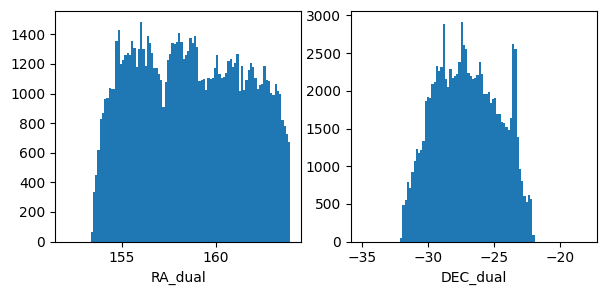

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(7, 3)
selection = result_table['s2n_r_auto_dual'] > 10
ax1.hist(result_table['RA_dual'][selection], bins=100, range=[152, 164])
ax1.set_xlabel('RA_dual')
ax2.hist(result_table['DEC_dual'][selection], bins=100, range=[-35, -18])
ax2.set_xlabel('DEC_dual')

Text(0, 0.5, '(g - i)_auto')

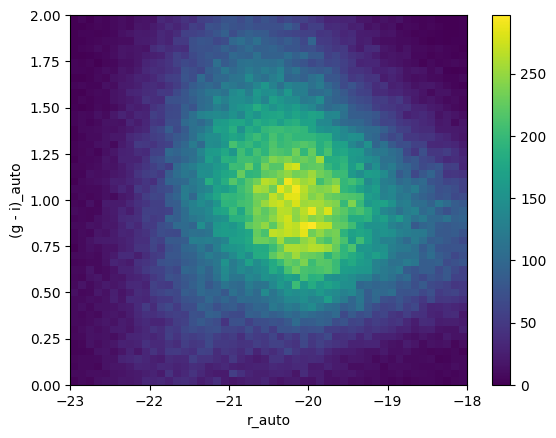

In [12]:
g_r = result_table['g_auto_dual'] - result_table['r_auto_dual']
r = result_table['r_auto_dual']
SNr = result_table['s2n_r_auto_dual']

SN = 10
mask = (result_table['s2n_r_auto_dual'] > SN) | (result_table['s2n_g_auto_dual'] > SN)
mr = np.ma.masked_array(r, mask)
mg_r = np.ma.masked_array(g_r, mask)
mSNr = np.ma.masked_array(SNr, mask)
f, ax = plt.subplots()
#im = ax.hexbin(-mM, mc, bins=50, extent=[-23, -18, 0, 2])
_, _, _, im = ax.hist2d(-mr, mg_r, bins=50, range=[[-23, -18], [0, 2]])
plt.colorbar(im, ax=ax)
#ax.set_xlim(-23, -10)
#ax.set_ylim(0, 3)
ax.set_xlabel('r_auto')
ax.set_ylabel('(g - i)_auto')